In [7]:
print("Instalando mediapipe y opencv-python...")
# Se instala mediapipe primero para que traiga su numpy compatible
!pip install mediapipe opencv-python

Instalando mediapipe y opencv-python...
  Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl (35.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 9.3 MB/s eta 0:00:00


--- Analizando Vídeo Profesional ---

--- Analizando Vídeo Amateur ---

--- Profesional (Frame 145) ---


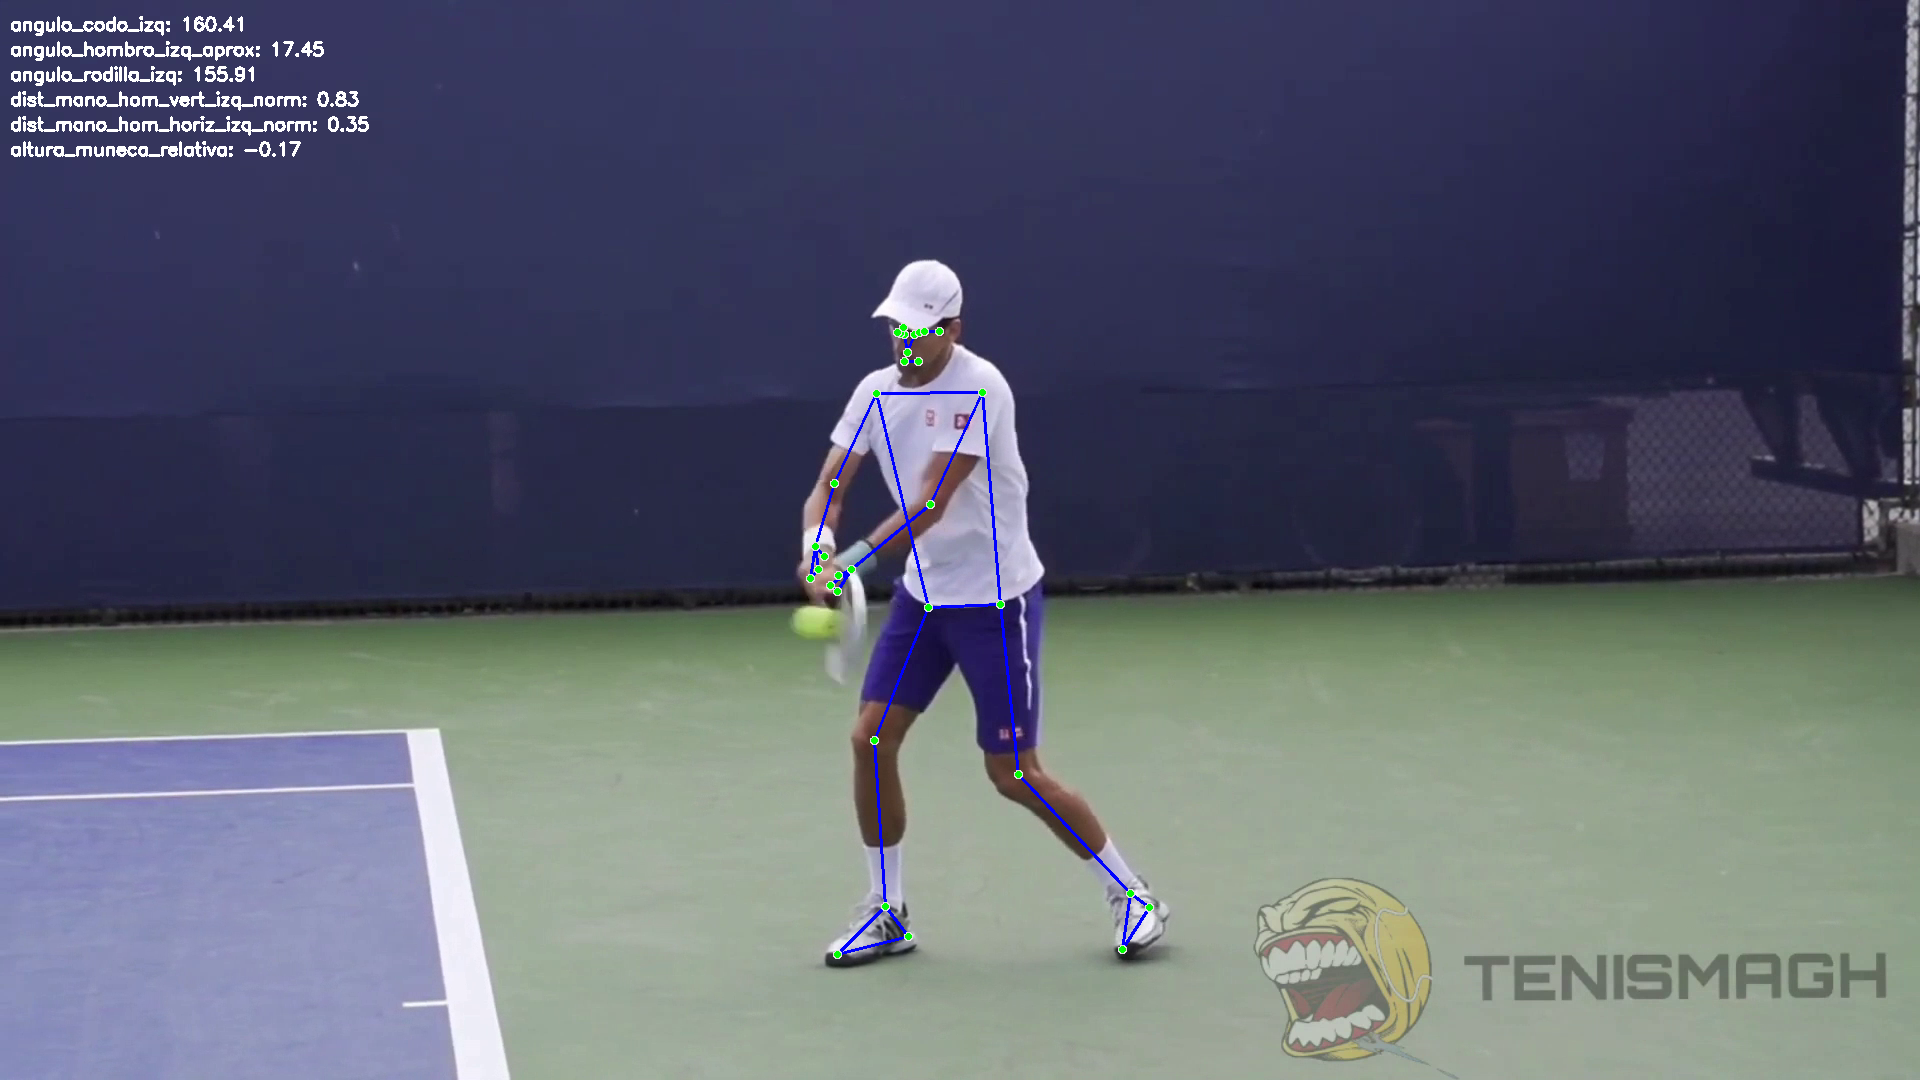

   Angulo Codo Izq: 160.41
   Angulo Hombro Izq Aprox: 17.45
   Angulo Rodilla Izq: 155.91
   Dist Mano Hom Vert Izq Norm: 0.83
   Dist Mano Hom Horiz Izq Norm: 0.35
   Altura Muneca Relativa: -0.17

--- Amateur (Frame 30) ---


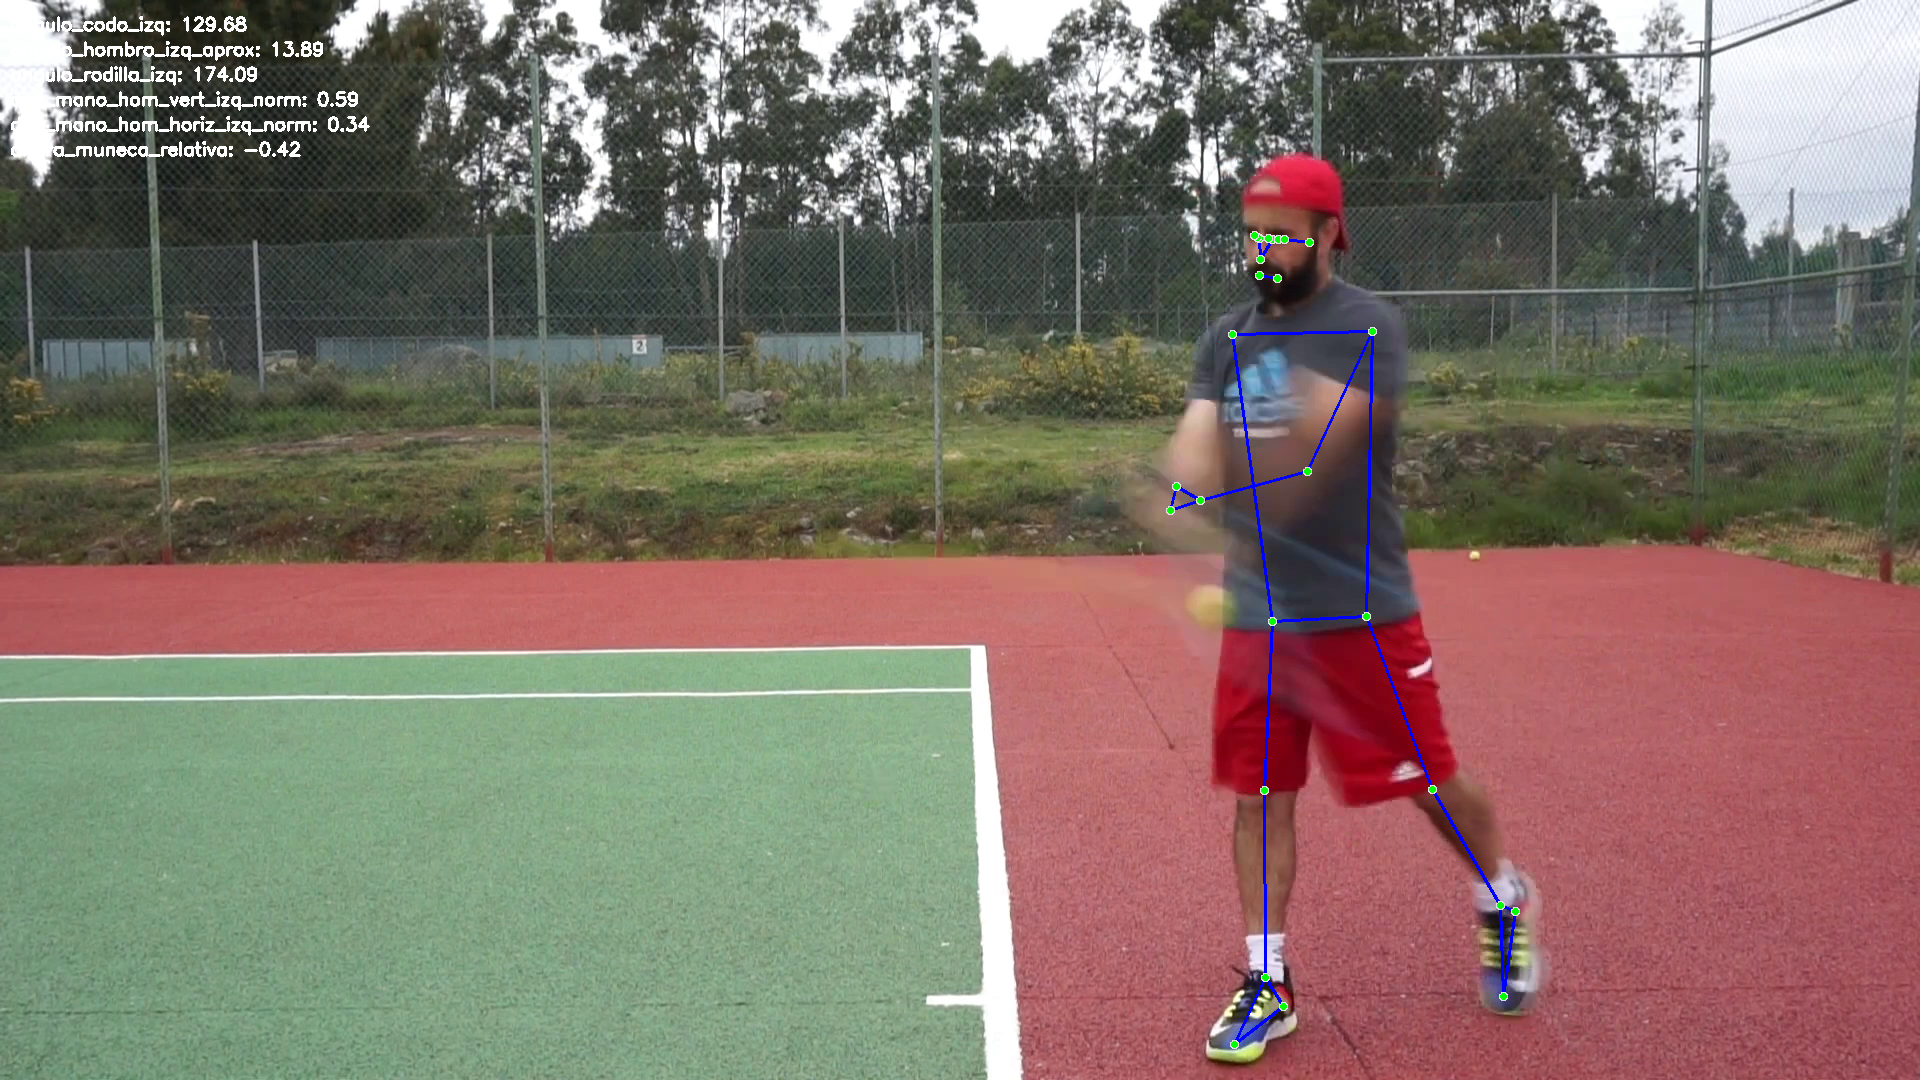

   Angulo Codo Izq: 129.68
   Angulo Hombro Izq Aprox: 13.89
   Angulo Rodilla Izq: 174.09
   Dist Mano Hom Vert Izq Norm: 0.59
   Dist Mano Hom Horiz Izq Norm: 0.34
   Altura Muneca Relativa: -0.42

--- Comparación de Parámetros Clave (Solo para el primer frame de contacto) ---
Parámetro                                | Profesional     | Amateur        
---------------------------------------------------------------------------
Angulo Codo Izq                          | 160.41          | 129.68         
Angulo Hombro Izq Aprox                  | 17.45           | 13.89          
Angulo Rodilla Izq                       | 155.91          | 174.09         
Dist Mano Hom Vert Izq Norm              | 0.83            | 0.59           
Dist Mano Hom Horiz Izq Norm             | 0.35            | 0.34           
Altura Muneca Relativa                   | -0.17           | -0.42          


In [4]:
import cv2
import mediapipe as mp
import numpy as np
import math
import os
from google.colab.patches import cv2_imshow # Importa la función para mostrar imágenes en Colab

# --- Inicialización global de MediaPipe Pose ---
mp_pose = mp.solutions.pose
pose_detector = mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# --- Funciones Auxiliares ---
def calcular_angulo(p1, p2, p3):
    v1 = np.array([p1.x - p2.x, p1.y - p2.y])
    v2 = np.array([p3.x - p2.x, p3.y - p2.y])

    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    if norm_v1 == 0 or norm_v2 == 0:
        return 0

    cos_angle = dot_product / (norm_v1 * norm_v2)
    cos_angle = np.clip(cos_angle, -1.0, 1.0)

    angulo_rad = np.arccos(cos_angle)
    angulo_deg = np.degrees(angulo_rad)
    return angulo_deg

def calcular_distancia(p1, p2):
    return math.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)

def extraer_frames(ruta_video, carpeta_destino="frames"):
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)

    cap = cv2.VideoCapture(ruta_video)
    if not cap.isOpened():
        print(f"Error: No se pudo abrir el vídeo: {ruta_video}")
        return

    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Vídeo: {ruta_video}, FPS: {frame_rate:.2f}, Total Frames: {frame_count}")

    frame_num = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        nombre_archivo = f"{carpeta_destino}/frame_{frame_num:04d}.jpg"
        cv2.imwrite(nombre_archivo, frame)
        frame_num += 1

    cap.release()
    print(f"Se extrajeron {frame_num} frames y se guardaron en '{carpeta_destino}'.")


def obtener_parametros_pose(landmarks):
    parametros = {}

    try:
        # Lado Izquierdo
        hombro_izq = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
        codo_izq = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW]
        muneca_izq = landmarks[mp_pose.PoseLandmark.LEFT_WRIST]
        cadera_izq = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
        rodilla_izq = landmarks[mp_pose.PoseLandmark.LEFT_KNEE]
        tobillo_izq = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE]

        # Lado Derecho (necesario para cadera_media_y)
        cadera_der = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]

        # --- Ángulo del Codo Izquierdo ---
        parametros['angulo_codo_izq'] = calcular_angulo(hombro_izq, codo_izq, muneca_izq)

        # --- Ángulo del Hombro Izquierdo (Aproximado en plano sagital) ---
        parametros['angulo_hombro_izq_aprox'] = calcular_angulo(cadera_izq, hombro_izq, codo_izq)

        # --- Ángulo de la Rodilla Izquierda ---
        parametros['angulo_rodilla_izq'] = calcular_angulo(cadera_izq, rodilla_izq, tobillo_izq)

        # --- Distancia Vertical Mano-Hombro Izquierdo (normalizada por altura del torso) ---
        altura_torso = abs(hombro_izq.y - cadera_izq.y)
        if altura_torso > 0:
            parametros['dist_mano_hom_vert_izq_norm'] = abs(muneca_izq.y - hombro_izq.y) / altura_torso
        else:
            parametros['dist_mano_hom_vert_izq_norm'] = None

        # --- Distancia Horizontal Mano-Hombro Izquierdo (normalizada) ---
        if altura_torso > 0:
            parametros['dist_mano_hom_horiz_izq_norm'] = abs(muneca_izq.x - hombro_izq.x) / altura_torso
        else:
            parametros['dist_mano_hom_horiz_izq_norm'] = None

        # --- Altura de la Muneca en relacion al cuerpo (ej. golpe alto o bajo) ---
        # Promedio de las caderas como referencia central
        cadera_media_y = (cadera_izq.y + cadera_der.y) / 2

        # Normalizar por la altura del torso
        if altura_torso > 0:
            # El valor es negativo si está por encima de la cadera (Y de muñeca es menor que Y de cadera media)
            parametros['altura_muneca_relativa'] = (muneca_izq.y - cadera_media_y) / altura_torso
        else:
            parametros['altura_muneca_relativa'] = None

    except Exception as e:
        print(f"Error al calcular parámetros de pose: {e}. Algunos landmarks podrían no estar detectados o el modelo no detectó la pose completa.")
        pass

    return parametros

def analizar_frame_individual(frame, pose_model):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose_model.process(rgb_frame)

    anotated_frame = frame.copy()
    parametros_pose = {}
    landmarks_detectados = None

    if results.pose_landmarks:
        landmarks_detectados = results.pose_landmarks.landmark
        parametros_pose = obtener_parametros_pose(landmarks_detectados)

        mp.solutions.drawing_utils.draw_landmarks(
            anotated_frame,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
            connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2)
        )

        y_offset = 30
        for key, value in parametros_pose.items():
            if value is not None:
                cv2.putText(anotated_frame, f"{key}: {value:.2f}", (10, y_offset),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            y_offset += 25

    return anotated_frame, parametros_pose, landmarks_detectados

def procesar_video_y_analizar_frames_clave(ruta_video, frames_clave, pose_model):
    resultados_dict = {}
    cap = cv2.VideoCapture(ruta_video)
    if not cap.isOpened():
        print(f"Error: No se pudo abrir el vídeo: {ruta_video}")
        return resultados_dict

    for frame_num in frames_clave:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()

        if ret:
            anotated_frame, parametros, _ = analizar_frame_individual(frame, pose_model)
            resultados_dict[frame_num] = {
                'frame_anotado': anotated_frame,
                'parametros': parametros
            }
        else:
            print(f"Advertencia: No se pudo leer el frame {frame_num} de {ruta_video}")

    cap.release()
    return resultados_dict

# --- Rutas de los vídeos ---
video_pro = '/content/novak.mp4'
video_amateur = '/content/amateur.mp4'

# --- Frames clave para el análisis (ejemplo: punto de contacto) ---
frames_contacto_pro = [145]
frames_contacto_ama = [30]

# --- Ejecución del Análisis ---
print("--- Analizando Vídeo Profesional ---")
resultados_pro_dict = procesar_video_y_analizar_frames_clave(video_pro, frames_contacto_pro, pose_detector)

print("\n--- Analizando Vídeo Amateur ---")
resultados_ama_dict = procesar_video_y_analizar_frames_clave(video_amateur, frames_contacto_ama, pose_detector)


# --- Mostrar y Comparar Resultados ---

def mostrar_resultados_frame(tipo_jugador, frame_num, data):
    print(f"\n--- {tipo_jugador} (Frame {frame_num}) ---")
    if data and data['frame_anotado'] is not None:
        cv2_imshow(data['frame_anotado'])
        if data['parametros']:
            for key, value in data['parametros'].items():
                if value is not None:
                    print(f"   {key.replace('_', ' ').title()}: {value:.2f}")
                else:
                    print(f"   {key.replace('_', ' ').title()}: No detectado/N.A.")
        else:
            print("No se detectaron parámetros de pose para este frame.")
    else:
        print(f"No se pudo procesar el frame {frame_num} para {tipo_jugador}.")

# Mostrar resultados para el profesional
for frame_num, data in resultados_pro_dict.items():
    mostrar_resultados_frame("Profesional", frame_num, data)

# Mostrar resultados para el amateur
for frame_num, data in resultados_ama_dict.items():
    mostrar_resultados_frame("Amateur", frame_num, data)

# --- Opcional: Comparación de Parámetros ---
print("\n--- Comparación de Parámetros Clave (Solo para el primer frame de contacto) ---")
if resultados_pro_dict and resultados_ama_dict:
    primer_frame_pro = next(iter(resultados_pro_dict.keys()))
    primer_frame_ama = next(iter(resultados_ama_dict.keys()))

    params_pro = resultados_pro_dict[primer_frame_pro]['parametros']
    params_ama = resultados_ama_dict[primer_frame_ama]['parametros']

    print(f"{'Parámetro':<40} | {'Profesional':<15} | {'Amateur':<15}")
    print("-" * 75)

    parametros_a_comparar = [
        'angulo_codo_izq',
        'angulo_hombro_izq_aprox',
        'angulo_rodilla_izq',
        'dist_mano_hom_vert_izq_norm',
        'dist_mano_hom_horiz_izq_norm',
        'altura_muneca_relativa' # Esta línea ya estaba, solo necesitaba la corrección en la función obtener_parametros_pose
    ]

    for key in parametros_a_comparar:
        val_pro = f"{params_pro.get(key, 'N/A'):.2f}" if isinstance(params_pro.get(key), (int, float)) else str(params_pro.get(key, 'N/A'))
        val_ama = f"{params_ama.get(key, 'N/A'):.2f}" if isinstance(params_ama.get(key), (int, float)) else str(params_ama.get(key, 'N/A'))
        print(f"{key.replace('_', ' ').title():<40} | {val_pro:<15} | {val_ama:<15}")
else:
    print("No hay suficientes datos para la comparación.")

## Dist Mano - Hombro Vertical y Horizontal Izquierdos Normalizada

* Si la distancia (muñeca izquierda - hombro izquierdo verticalmente) es menor sugiere un punto de contacto más alto o con el brazo más flexionado o encogido.

* En un valor más alto (muñeca izquierda - hombro izquierdo horizontalmente) indica que la muñeca está más alejada horizontalmente del hombro lo que sugiere un contacto de la pelota más hacia adelante.

## Altura Muñeca Relativa respecto a la cadera (Muñeca - Cadera)

* Un valor negativo, significa que la muñeca está por encima de la línea o posición media de las caderas. Cuanto más negativo, más alta está la muñeca con respecto a la cadera.

* Un valor cercano a 0 significa que la muñeca está aproximadamente a la altura de la línea de las caderas.